In [ ]:
import os
import pickle
os.environ

# 7.4 Ragasによる合成テストデータの作成

In [ ]:
from langchain_community.document_loaders import GitLoader

def file_filter(file_path: str) -> bool:
    return file_path.endswith(".mdx")

loader = GitLoader(
    clone_url="https://github.com/langchain-ai/langchain",
    repo_path="./langchain",
    branch="langchain==0.2.13", # "master"
    file_filter=file_filter
)

"""
書籍執筆時からドキュメントの数が増えたため、masterだと後の処理でOPENAIのrate limitに引っかかるらしい。ので、branchを指定する。
(ref: https://github.com/GenerativeAgents/agent-book/blob/main/chapter07/notebook.ipynb)
"""

# documents = loader.load()
documents = pickle.load(open("documents.pickle", "rb"))

print(len(documents))

In [ ]:
# Ragasが使用するmetadata filenameを付与する
for document in documents:
    document.metadata["filename"] = document.metadata["source"]

In [ ]:
import nest_asyncio
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

nest_asyncio.apply()
# asyncioをjupyter notebookの中などで使えるようになるおまじない

generator = TestsetGenerator.from_langchain(
    generator_llm=ChatOpenAI(model="gpt-4o-mini"),  # テストを生成するLLMモデル
    critic_llm=ChatOpenAI(model="gpt-4o-mini"),     # 生成されたテストを評価するLLM
    embeddings=OpenAIEmbeddings(),
)

"""
testset = generator.generate_with_langchain_docs(
    documents,
    test_size=4,
    distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25}
)
# simple: 単純な質問, reasoning: 推論が必要な質問, multi_context: 回答に複数の情報源が必要
"""
testset = pickle.load(open("testset.pickle", "rb"))




なんかプログレスが出た
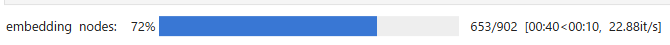

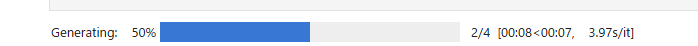


# 参考 テストデータの生成

simpleの場合。seed_question_promptにcontextやkeyphraseを与えている。
https://github.com/explodinggradients/ragas/blob/v0.1.14/src/ragas/testset/evolutions.py#L306
```
        results = await self.generator_llm.generate(
            prompt=self.seed_question_prompt.format(
                context=merged_node.page_content,
                keyphrase=self.run_config.rng.choice(
                    np.array(merged_node.keyphrases), size=1
                )[0],
            )
        )
```

### seed_question_prompt
https://github.com/explodinggradients/ragas/blob/v0.1.14/src/ragas/testset/prompts.py#L217-L241

```
seed_question_prompt = Prompt(
    name="seed_question",
    instruction="Generate a question that can be fully answered from given context. The question should be formed using topic",
    examples=[
        {
            "context": "Photosynthesis in plants involves converting light energy into chemical energy, using chlorophyll and other pigments to absorb light. This process is crucial for plant growth and the production of oxygen.",
            "keyphrase": "Photosynthesis",
            "question": "What is the role of photosynthesis in plant growth?",
        },
        {
            "context": "The Industrial Revolution, starting in the 18th century, marked a major turning point in history as it led to the development of factories and urbanization.",
            "keyphrase": "Industrial Revolution",
            "question": "How did the Industrial Revolution mark a major turning point in history?",
        },
        {
            "context": "The process of evaporation plays a crucial role in the water cycle, converting water from liquid to vapor and allowing it to rise into the atmosphere.",
            "keyphrase": "Evaporation",
            "question": "Why is evaporation important in the water cycle?",
        },
    ],
    input_keys=["context", "keyphrase"],
    output_key="question",
    output_type="str",
)
```


### reasoning question

```
reasoning_question_prompt = Prompt(
    name="reasoning_question",
    instruction="""Complicate the given question by rewriting question into a multi-hop reasoning question based on the provided context.
    Answering the question should require the reader to make multiple logical connections or inferences using the information available in given context.
    Rules to follow when rewriting question:
    1. Ensure that the rewritten question can be answered entirely from the information present in the contexts.
    2. Do not frame questions that contains more than 15 words. Use abbreviation wherever possible.
    3. Make sure the question is clear and unambiguous.
    4. phrases like 'based on the provided context','according to the context',etc are not allowed to appear in the question.""",
    examples=[
        {
            "question": "What is the capital of France?",
            "context": "France is a country in Western Europe. It has several cities, including Paris, Lyon, and Marseille. Paris is not only known for its cultural landmarks like the Eiffel Tower and the Louvre Museum but also as the administrative center.",
            "output": "Linking the Eiffel Tower and administrative center, which city stands as both?",
        },
        {
            "question": "What does the append() method do in Python?",
            "context": "In Python, lists are used to store multiple items in a single variable. Lists are one of 4 built-in data types used to store collections of data. The append() method adds a single item to the end of a list.",
            "output": "If a list represents a variable collection, what method extends it by one item?",
        },
    ],
    input_keys=["question", "context"],
    output_key="output",
    output_type="str",
    language="english",
)
```

### multi_context
```
multi_context_question_prompt = Prompt(
    name="multi_context_question",
    instruction="""
    The task is to rewrite and complicate the given question in a way that answering it requires information derived from both context1 and context2. 
    Follow the rules given below while rewriting the question.
        1. The rewritten question should not be very long. Use abbreviation wherever possible.
        2. The rewritten question must be reasonable and must be understood and responded by humans.
        3. The rewritten question must be fully answerable from information present in context1 and context2. 
        4. Read and understand both contexts and rewrite the question so that answering requires insight from both context1 and context2.
        5. phrases like 'based on the provided context','according to the context?',etc are not allowed to appear in the question.""",
    examples=[
        {
            "question": "What process turns plants green?",
            "context1": "Chlorophyll is the pigment that gives plants their green color and helps them photosynthesize.",
            "context2": "Photosynthesis in plants typically occurs in the leaves where chloroplasts are concentrated.",
            "output": "In which plant structures does the pigment responsible for their verdancy facilitate energy production?",
        },
        {
            "question": "How do you calculate the area of a rectangle?",
            "context1": "The area of a shape is calculated based on the shape's dimensions. For rectangles, this involves multiplying the length and width.",
            "context2": "Rectangles have four sides with opposite sides being equal in length. They are a type of quadrilateral.",
            "output": "What multiplication involving equal opposites yields a quadrilateral's area?",
        },
    ],
    input_keys=["question", "context1", "context2"],
    output_key="output",
    output_type="str",
    language="english",
)
```

In [ ]:
import pickle
pickle.dump(documents, open("documents.pickle", "wb"))
pickle.dump(testset, open("testset.pickle", "wb"))

In [ ]:
testset.test_data[0]

In [ ]:
testset.to_pandas()

## LangSmithのDatasetの作成


In [ ]:
from langsmith import Client

dataset_name = "agent-book"

client = Client()

if client.has_dataset(dataset_name=dataset_name):
    client.delete_dataset(dataset_name=dataset_name)
dataset = client.create_dataset(dataset_name=dataset_name)

LangSmithにDatasetができた。
ここにさっき作ったtestdataを入れていく
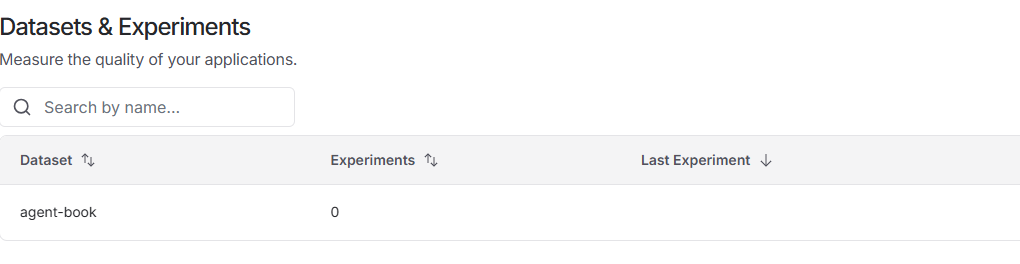

In [ ]:
# testdata作成用に整形
inputs = []
outputs = []
metadatas = []

for testset_record in testset.test_data:
    inputs.append({
        "question": testset_record.question})
    outputs.append({
        "contexts": testset_record.contexts,
        "ground_truth": testset_record.ground_truth,
    })
    metadatas.append({
        "source": testset_record.metadata[0]["source"],
        "evolution_type": testset_record.evolution_type,
    })

In [ ]:
# langsmithでは1つ1つのテストデータのことをexampleと呼ぶ
client.create_examples(
    inputs=inputs,
    outputs=outputs,
    metadata=metadatas,
    dataset_id=dataset.id,
)

LangSmithのDatasetのExamplesが増えた
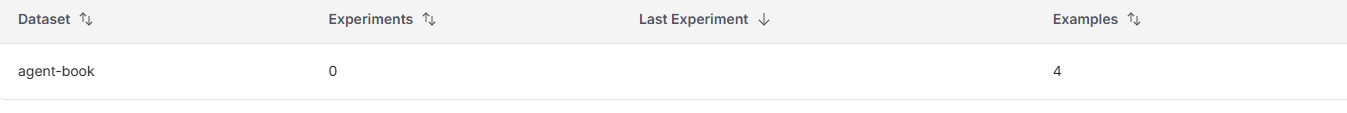

Exampleの例
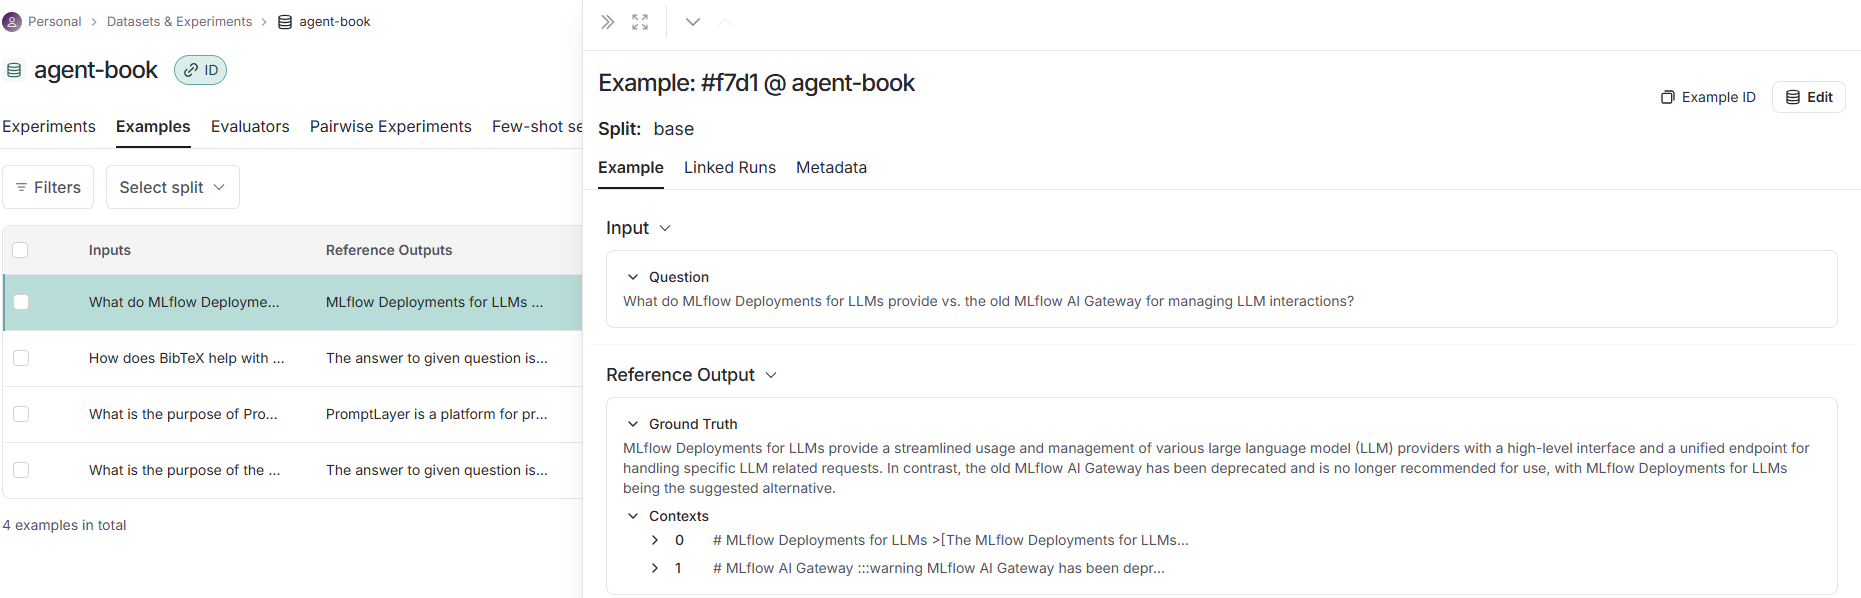

- データのバージョニングも自動でしてくれる
- データはUI上で追加したり、CSVインポートしたりもできる

# 7.5 LangSmithとRagasを使ったオフライン評価の実装

langsmithのevaluate関数を使って評価する。
推論処理をするpredictと評価指標を実装しているevaluatorsを用意する。

```
from langsmith.evaluation import evaluate

evaluate(
    predict,
    data="agent-book",
    evaluators=evaluators
)
```


## 利用可能なEvaluator

- LangChain提供のもの
  - LLMによる評価、埋め込みベクトルの類似度、レーベンシュタイン距離など

- 独自定義したもの
  - 今回はRagasの評価メトリクスを使った独自定義したEvaluatorを作る
 
## Ragasの評価メトリクス

- 検索の評価メトリクス：Context recall, Context precision, Context entity recall
- 生成の評価メトリクス: Faithfulness, Answer, relevancy
- 検索+生成の評価メトリクス: Anaswer similarity, Answer correctness

| 評価対象  | メトリクス                 | 概要                                                                     | LLMを使用 | Embeddingを使用 |
| ----- | --------------------- | ---------------------------------------------------------------------- | ------ | ------------ |
| 検索    | Context precision     | 質問と期待する回答を踏まえて、実際の検索結果のうち有用だとLLMで推論される割合                               | 〇      |              |
|       | Context Recall        | 期待する回答をいくつかの文章に分割したうち、実際の検索結果で説明できる割合                                  | 〇      |              |
|       | Context entity recall | 期待する回答に含まれるエンティティ(物事)のうち、実際の検索結果に含まれる割合                                | 〇      |              |
| 生成    | Answer relevancy      | 実際の回答が質問にどれだけ関連するか<br>(実際の回答からLLMで推論した質問と、もとの質問の、埋め込みベクトルのコサイン類似度の平均値) | 〇      | 〇            |
|       | Faithfulness          | 実際の回答に含まれる主張のうち、実際の検索結果と一貫している割合                                       | 〇      |              |
| 検索+生成 | Answer similarity     | 実際の回答と期待する回答の、埋め込みベクトルのコサイン類似度                                         |        | 〇            |
|       | Answer correctness    | 実際の回答と期待する回答の、事実的類似性と意味的類似性の加重平均                                     | 〇      | 〇            |

今回は Context precisionとAnswer relevancyの2つを実装していく

## カスタムEvaluatorの実装
evaluatorは以下のインターフェースの関数を実装して使える

```
def my_evaluator(run: Run, example: Example) -> dict[str, Any]:
    return {"key": "sample_metric", "score": 1}
```


In [ ]:
from typing import Any

from langchain_core.embeddings import Embeddings
from langchain_core.language_models import BaseChatModel
from langsmith.schemas import Example, Run
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.llms import LangchainLLMWrapper
from ragas.metrics.base import Metric, MetricWithEmbeddings, MetricWithLLM

class RagasMetricEvaluator:
    def __init__(self, metric: Metric, llm: BaseChatModel, embeddings: Embeddings):
        self.metric = metric

        if isinstance(self.metric, MetricWithLLM):
            self.metric.llm = LangchainLLMWrapper(llm)
        if isinstance(self.metric, MetricWithEmbeddings):
            self.metric.embeddings = LangchainEmbeddingsWrapper(embeddings)

    def evaluate(self, run: Run, example: Example) -> dict[str, Any]:
        context_strs = [doc.page_content for doc in run.outputs["contexts"]]

        # ここで評価スコアを算出する
        score = self.metric.score({
            "question": example.inputs["question"],  # 質問
            "answer": run.outputs["answer"],         # 実際の回答
            "contexts": context_strs,                # 実際の検索結果
            "ground_truth": example.outputs["ground_truth"], # 期待する回答
        })
        return {"key": self.metric.name, "score": score}

In [ ]:
# カスタムEvaluatorにRagasの評価メトリクスをセット

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.metrics import answer_relevancy, context_precision

metrics = [context_precision, answer_relevancy]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

evaluators = [
    RagasMetricEvaluator(metric, llm, embeddings).evaluate
    for metric in metrics
]

## 推論の関数の実装

In [ ]:
# DBの用意
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
db = Chroma.from_documents(documents, embeddings)


In [ ]:
db.get(limit=1)

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_template('''\
                                          以下の文脈だけを踏まえて質問に回答してください。
                                          文脈: """
                                          {context}
                                          """

                                          質問: {question}
                                          '''
                                         )
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
retriever = db.as_retriever()
chain = RunnableParallel(
    {
        "question": RunnablePassthrough(),
        "context": retriever,
    }
).assign(answer=prompt | model | StrOutputParser())


In [ ]:
# 推論用関数
def predict(inputs: dict[str, Any]) -> dict[str, Any]:
    question = inputs["question"]
    output = chain.invoke(question)
    return {
        "contexts": output["context"],
        "answer": output["answer"],
    }

In [ ]:
# テストの実行
from langsmith.evaluation import evaluate

evaluate(
    predict,
    data="agent-book",
    evaluators=evaluators,
)


LangSmithに結果が登録される

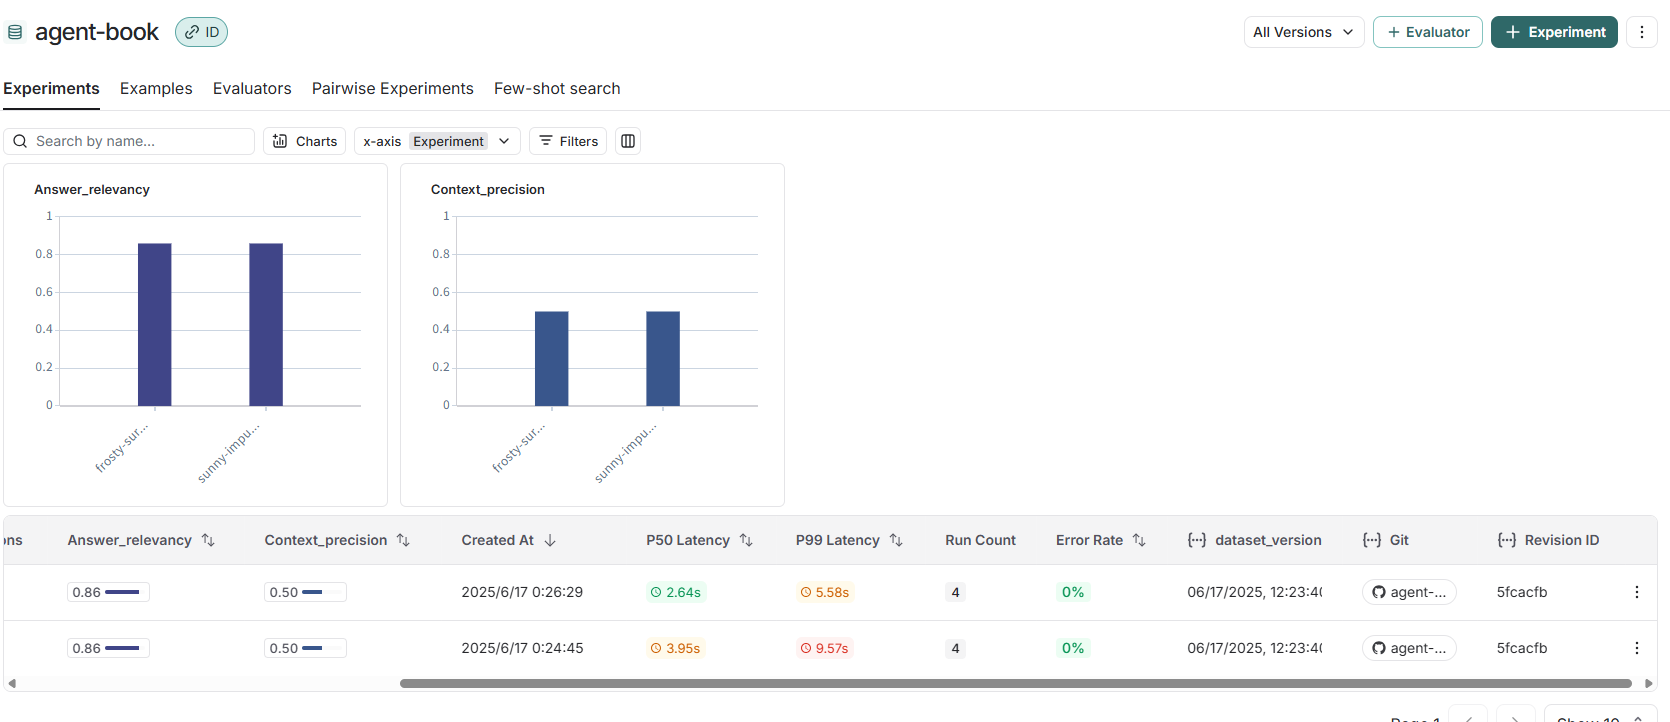

このほかにもLangSmithにはペアワイズ評価 (2つのLLMの結果を見せてどっちが良いか評価させる)ものもある。
https://docs.smith.langchain.com/evaluation/how_to_guides/evaluate_pairwise

# 7.6 LangSmithを使ったフィードバックの収集

デプロイした後にユーザからのフィードバックを収集して評価を行っていく。
ここではGood/Badの評価が届くようなものを作る

In [ ]:
from uuid import UUID

import ipywidgets as widgets
from IPython.display import display
from langsmith import Client

output = widgets.Output(layour={'border': '1px solid black'})


def display_feedback_buttons(run_id: UUID) -> None:
    good_button = widgets.Button(
        description="Good",
        button_style="success",
        icon="thumbs-up",
    )
    bad_button = widgets.Button(
    description="Bad",
    button_style="danger",
    icon="thumbs-down",
    )

    def on_button_clicked(button: widgets.Button) -> None:
        with output:
            print("buttonがクリックされました")
        if button == good_button:
            score = 1
        elif button == bad_button:
            score = 0
        else:
            raise ValueError(f"Unknown button: {button}")
        with output:
            client = Client(api_key=os.environ["LANGCHAIN_API_KEY"])
            # langsmithのclientのcreate_feedbackメソッドでfeedbackを送る
            client.create_feedback(run_id=run_id, key="thumbs", score=score)
        
            print("フィードバックを送信しました")

    good_button.on_click(on_button_clicked)
    bad_button.on_click(on_button_clicked)

    display(good_button, bad_button, output)


In [ ]:
from langchain_core.tracers.context import collect_runs

with collect_runs() as runs_cb:
    llm_output = chain.invoke("LangChainの概要を教えて")
    print(llm_output["answer"])
    run_id = runs_cb.traced_runs[0].id
    print(run_id)

display_feedback_buttons(run_id)

In [ ]:
os.environ

# 7.7 フィードバックの活用のための自動処理

LangSmithのAutomation rule機能を使って、Good/Badのスコアによって処理を行う例を構築する

## Automation ruleによる処理

フィルタ条件にマッチしたトレースをサンプリングして自動でアクションやアラートを実行できる。
利用例
- 良い評価のトレースを自動でDatasetに追加して、オフライン評価・Few-shotプロンプティング・ファインチューニングに活用
- 悪い評価を受けたトレースを自動的にAnnotation Queueに追加して人間が確認する対象にする

本書では良い評価の例をつくる


フィルタでthumbs is 1を作る

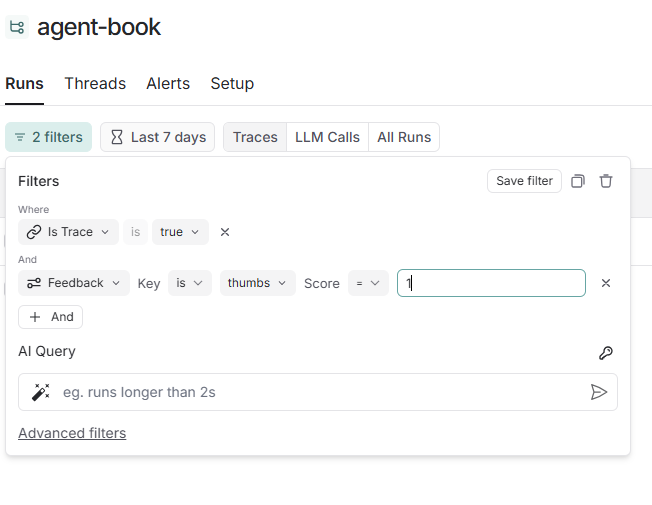

datasetを作る画面が変わってる。。。
Dataset typeがない。schema空で作ってみる

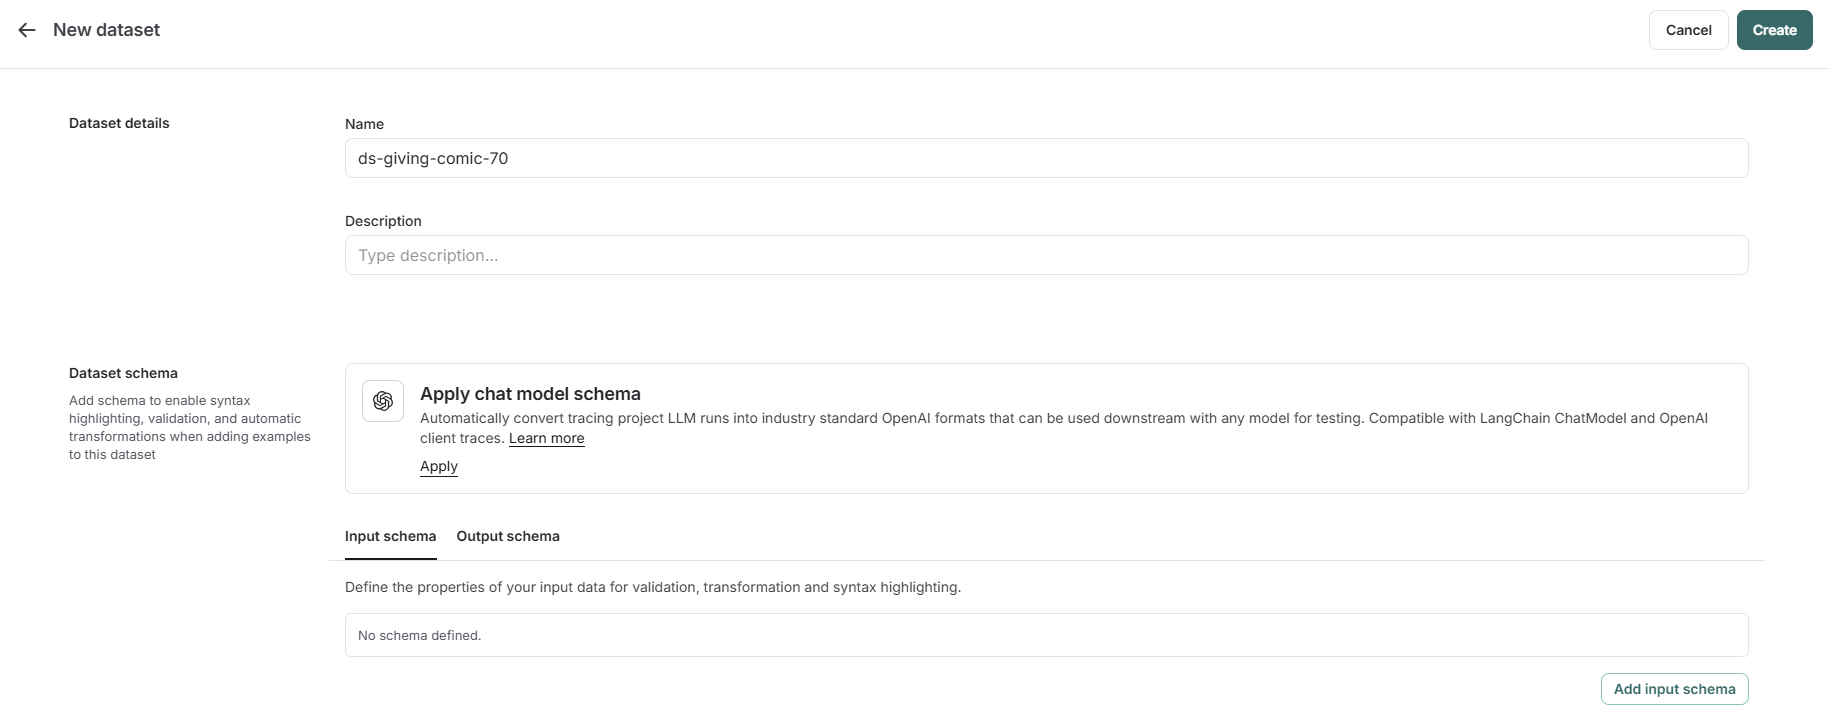

feedback goodを押すと
exampleが増えていく



同様に悪い評価をAnnotation queueにためていき、人手で確認させることもできる